---

**Unleash Your Creativity: Image-to-Image Generation with Stable Diffusion**

Hello and welcome! Whether you're an artist, engineer, or simply someone curious about the blend of art and technology, this is the place for you.

Imagine taking a picture and a few words of inspiration, and watching as they transform into a new visual representation. With Stable Diffusion, this imaginative exercise becomes a tangible experience. Want to see a landscape shift from day to night? Or perhaps turn a doodle into a detailed artwork? Dive in to explore these possibilities and more.

Behind the scenes, we're harnessing the power of Intel® Data Center GPU Max Series GPUs.

This guide is designed to be straightforward and user-friendly. No deep technical knowledge required, just a spark of creativity and a dash of curiosity.

Ready to get started? Let's begin by setting up a few things and diving into the experience!


In [4]:
# Required packages, install if not installed (assume PyTorch* and Intel® Extension for PyTorch* is already present)
!echo "Installation in progress..."
# import sys
# !{sys.executable} -m pip install  invisible-watermark > /dev/null
# !conda install -y --quiet --prefix {sys.prefix}  -c conda-forge \
#     accelerate==0.23.0 \
#     validators==0.22.0 \
#     diffusers==0.18.2 \
#     transformers==4.32.1 \
#     tensorboardX \
#     pillow \
#     ipywidgets \
#     ipython > /dev/null && echo "Installation successful" || echo "Installation failed"
import sys
!{sys.executable} -m pip install invisible-watermark --user > /dev/null 2>&1 
#!{sys.executable} -m pip install transformers huggingface-hub --user > /dev/null 2>&1
!echo "Installtion complete..."


from io import BytesIO
import os
import time
import warnings
from pathlib import Path
from typing import List, Dict, Tuple


# Suppress warnings for a cleaner output.
warnings.filterwarnings("ignore")

import random
import requests
import torch
import torch.nn as nn
import intel_extension_for_pytorch as ipex  # adds xpu namespace to PyTorch, enabling you to use Intel GPUs
# A big issue here, if no xpus are available will need to change every mention of xpu to cpu to get it to work.
import validators
import numpy as np

from PIL import Image
from diffusers import StableDiffusionImg2ImgPipeline
from diffusers import DPMSolverMultistepScheduler

import os
import random
import time

import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mp_img
import validators

from IPython.display import clear_output
from IPython.display import display
from IPython.display import HTML
from IPython.display import Image as IPImage
from ipywidgets import VBox, HBox


class Img2ImgModel:
    """
    This class creates a model for transforming images based on given prompts.
    """

    def __init__(
        self,
        model_id_or_path: str,
        device: str = "xpu",
        torch_dtype: torch.dtype = torch.bfloat16,
        optimize: bool = True,
        warmup: bool = False,
        scheduler: bool = True,
    ) -> None:
        """
        Initialize the model with the specified parameters.

        Args:
            model_id_or_path (str): The ID or path of the pre-trained model.
            device (str, optional): The device to run the model on. Defaults to "xpu".
            torch_dtype (torch.dtype, optional): The data type to use for the model. Defaults to torch.float16.
            optimize (bool, optional): Whether to optimize the model. Defaults to True.
        """
        self.device = device
        self.data_type = torch_dtype
        self.scheduler = scheduler
        self.generator = torch.Generator()  # .manual_seed(99)
        self.pipeline = self._load_pipeline(model_id_or_path, torch_dtype)
        if optimize:
            start_time = time.time()
            #print("Optimizing the model...")
            self.optimize_pipeline()
            #print(
            #    "Optimization completed in {:.2f} seconds.".format(
            #        time.time() - start_time
            #    )
            #)
        if warmup:
            self.warmup_model()

    def _load_pipeline(
        self, model_id_or_path: str, torch_dtype: torch.dtype
    ) -> StableDiffusionImg2ImgPipeline:
        """
        Load the pipeline for the model.

        Args:
            model_id_or_path (str): The ID or path of the pre-trained model.
            torch_dtype (torch.dtype): The data type to use for the model.

        Returns:
            StableDiffusionImg2ImgPipeline: The loaded pipeline.
        """
        print("Loading the model...")
        model_path = Path(f"/home/common/data/Big_Data/GenAI/{model_id_or_path}")
        
        if model_path.exists():
            #print(f"Loading the model from {model_path}...")
            load_path = model_path
        else:
            print("Using the default path for models...")
            load_path = model_id_or_path
            
        pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(
            load_path,
            torch_dtype=torch_dtype,
            use_safetensors=True,
            variant="fp16",
        )
        if self.scheduler:
            pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
                pipeline.scheduler.config
            )
        if not model_path.exists():
            try:
                print(f"Attempting to save the model to {model_path}...")
                pipeline.save_pretrained(f"{model_path}")
                print("Model saved.")
            except Exception as e:
                print(f"An error occurred while saving the model: {e}. Proceeding without saving.")
        pipeline = pipeline.to(self.device)
        #print("Model loaded.")
        return pipeline

    
    def _optimize_pipeline(self, pipeline: StableDiffusionImg2ImgPipeline) -> StableDiffusionImg2ImgPipeline:
        """
        Optimize the pipeline of the model.

        Args:
            pipeline (StableDiffusionImg2ImgPipeline): The pipeline to optimize.

        Returns:
            StableDiffusionImg2ImgPipeline: The optimized pipeline.
        """

        for attr in dir(pipeline):
            try:
                if isinstance(getattr(pipeline, attr), nn.Module):
                    setattr(
                        pipeline,
                        attr,
                        ipex.optimize(
                            getattr(pipeline, attr).eval(),
                            dtype=pipeline.text_encoder.dtype,
                            inplace=True,
                        ),
                    )
            except AttributeError:
                pass
        return pipeline

    def optimize_pipeline(self) -> None:
        """
        Optimize the pipeline of the model.
        """
        self.pipeline = self._optimize_pipeline(self.pipeline)

    def get_image_from_url(self, url: str, path: str) -> Image.Image:
        """
        Get an image from a URL or from a local path if it exists.

        Args:
            url (str): The URL of the image.
            path (str): The local path of the image.

        Returns:
            Image.Image: The loaded image.
        """
        response = requests.get(url)
        if response.status_code != 200:
            raise Exception(
                f"Failed to download image. Status code: {response.status_code}"
            )
        if not response.headers["content-type"].startswith("image"):
            raise Exception(
                f"URL does not point to an image. Content type: {response.headers['content-type']}"
            )
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img.save(path)
        img = img.resize((768, 512))
        return img

    def warmup_model(self):
        """
        Warms up the model by generating a sample image.
        """
        print("Setting up model...")
        start_time = time.time()
        image_url = "https://user-images.githubusercontent.com/786476/256401499-f010e3f8-6f8d-4e9f-9d1f-178d3571e7b9.png"
        try:
            self.generate_images(
                image_url=image_url,
                prompt="A beautiful day",
                num_images=1,
                save_path=".tmp",
            )
        except Exception:
            print("model warmup delayed...")
        #print(
        #    "Model is set up and ready! Warm-up completed in {:.2f} seconds.".format(
        #        time.time() - start_time
        #    )
        #)

    def get_inputs(self, prompt, batch_size=1):
        self.generator = [torch.Generator() for i in range(batch_size)]
        prompts = batch_size * [prompt]
        return {"prompt": prompts, "generator": self.generator}

    def generate_images(
        self,
        prompt: str,
        image_url: str,
        num_images: int = 5,
        num_inference_steps: int = 30,
        strength: float = 0.75,
        guidance_scale: float = 7.5,
        save_path: str = "image_to_image",
        batch_size: int = 1,
    ):
        """
        Generate images based on the provided prompt and variations.

        Args:
            prompt (str): The base prompt for the generation.
            image_url (str): The URL of the seed image.
            variations (List[str]): The list of variations to apply to the prompt.
            num_images (int, optional): The number of images to generate. Defaults to 5.
            num_inference_steps (int, optional): Number of noise removal steps.
            strength (float, optional): The strength of the transformation. Defaults to 0.75.
            guidance_scale (float, optional): The scale of the guidance. Defaults to 7.5.
            save_path (str, optional): The path to save the generated images. Defaults to "image_to_image".

        """
        input_image_path = "input.png"
        init_image = self.get_image_from_url(image_url, input_image_path)
        init_images = [init_image for _ in range(batch_size)]
        for i in range(0, num_images, batch_size):
            with torch.xpu.amp.autocast(
                enabled=True if self.data_type != torch.float32 else False,
                dtype=self.data_type,
            ):
                if batch_size > 1:
                    inputs = self.get_inputs(batch_size=batch_size, prompt=prompt)
                    images = self.pipeline(
                        **inputs,
                        image=init_images,
                        strength=strength,
                        guidance_scale=guidance_scale,
                        num_inference_steps=num_inference_steps,
                    ).images
                else:
                    images = self.pipeline(
                        prompt=prompt,
                        image=init_images,
                        strength=strength,
                        guidance_scale=guidance_scale,
                        num_inference_steps=num_inference_steps,
                    ).images

                for j in range(len(images)):
                    output_image_path = os.path.join(
                        save_path,
                        f"{'_'.join(prompt.split()[:3])}_{i+j}__{int(time.time() * 1e6)}.png",
                    )
                    images[j].save(output_image_path)


model_cache = {}

def image_to_image():
    out = widgets.Output()
    image_to_image_dir = "image_to_image"
    num_images = 2
    model_ids = [
        "runwayml/stable-diffusion-v1-5",
        "stabilityai/stable-diffusion-2-1",
    ]    
    model_dropdown = widgets.Dropdown(
        options=model_ids,
        value=model_ids[0],
        description="Model:",
    )    
    prompt_text = widgets.Text(
        value="",
        placeholder="Enter your prompt",
        description="Prompt:",
    )    
    num_images_slider = widgets.IntSlider(
        value=2,
        min=1,
        max=10,
        step=1,
        description="Images:",
    )    
    image_url_text = widgets.Text(
        value="https://user-images.githubusercontent.com/786476/256401499-f010e3f8-6f8d-4e9f-9d1f-178d3571e7b9.png",
        placeholder="Enter an image URL",
        description="Image URL:",
    )
    enhance_checkbox = widgets.Checkbox(
        value=False,
        description="Auto enhance the prompt?",
        disabled=False,
        indent=False
    )
    enhance_checkbox.layout.margin = "0 0 0 10px"
    num_images_slider.layout.margin = "0 0 0 8px"
    prompt_text.layout.width = "100%"
    layout = widgets.Layout(margin="0px 50px 10px 0px")
    button = widgets.Button(description="Generate Images!", button_style="primary")
    left_box = VBox([model_dropdown,num_images_slider], layout=layout)
    right_box = VBox([image_url_text, enhance_checkbox], layout=layout)
    user_input_widgets = HBox([left_box, right_box], layout=layout)
    prompt_text.layout.width = "57.5%"
    button.layout.margin = "35px"
    display(user_input_widgets)
    display( prompt_text)
    display(button)
    display(out)
    
    
    def on_submit(button):
        with out:
            clear_output(wait=True)
            print("Once generated, images will be saved to `./image_to_image` dir, please wait...")
            selected_model_index = model_ids.index(model_dropdown.value)
            model_id = model_ids[selected_model_index]
            model_key = (model_id, "xpu")
            prompt = prompt_text.value
            num_images = num_images_slider.value
            image_url = image_url_text.value
            
            if not validators.url(image_url):
                print("The input is not a valid URL. Using the default URL instead.")
                image_url = "https://user-images.githubusercontent.com/786476/256401499-f010e3f8-6f8d-4e9f-9d1f-178d3571e7b9.png"       
            #model = Img2ImgModel(model_id, device="xpu")
            if model_key not in model_cache:
                model_cache[model_key] = Img2ImgModel(model_id, device="xpu")
            model = model_cache[model_key]
            enhancements = [
            "purple light",
            "dreaming",
            "cyberpunk",
            "ancient" ", rustic",
            "gothic",
            "historical",
            "punchy",
            "photo" "vivid colors",
            "4k",
            "bright",
            "exquisite",
            "painting",
            "art",
            "fantasy [,/organic]",
            "detailed",
            "trending in artstation fantasy",
            "electric",
            "night",
            "neon",
            "midevil",
            "blocky",
            ]
            if not prompt:
                prompt = " "
            if enhance_checkbox.value:
                prompt = prompt + " " + " ".join(random.sample(enhancements, 5))
                print(f"Using enhanced prompt: {prompt}")    
            try:
                start_time = time.time()
                os.makedirs(image_to_image_dir, exist_ok=True)
                model.generate_images(
                    prompt=prompt,
                    image_url=image_url,
                    num_images=num_images,
                )
                clear_output(wait=True)
                display_generated_images()
            except KeyboardInterrupt:
                print("\nUser interrupted image generation...")
            except Exception as e:
                print(f"An error occurred: {e}")
            finally:
                status = f"Complete generating {num_images} images in {time.time() - start_time:.2f} seconds."
                #print(status)
    button.on_click(on_submit)

def display_generated_images(image_to_image_dir="image_to_image"):
    image_files = [f for f in os.listdir(image_to_image_dir) if f.endswith((".png", ".jpg"))]    
    num_images = len(image_files)
    num_columns = int(np.ceil(np.sqrt(num_images)))
    num_rows = int(np.ceil(num_images / num_columns))
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(10 * num_columns / num_columns, 10 * num_rows / num_rows))
    if num_images == 1:
        axs = np.array([[axs]])
    elif num_columns == 1 or num_rows == 1:
        axs = np.array([axs])
    for ax, image_file in zip(axs.ravel(), image_files):
        img = mp_img.imread(os.path.join(image_to_image_dir, image_file))
        ax.imshow(img)
        ax.axis("off")  # Hide axes
    for ax in axs.ravel()[num_images:]:
        ax.axis("off")
    plt.tight_layout()
    print(f"\nGenerated images...:")
    plt.show()


# from flask import Flask, request, send_from_directory, jsonify

# app = Flask(__name__)
# image_to_image_dir = "image_to_image"
# model_cache = {}


# @app.route("/process-image", methods=["POST"])
# def process_image():
#     try:
#         # Receive image from request
#         image_data = request.files["image"]
#         image = Image.open(BytesIO(image_data.read())).convert("RGB")

#         # Save received image
#         input_image_path = os.path.join(image_to_image_dir, "input.png")
#         image.save(input_image_path)

#         # Process image using Img2ImgModel
#         prompt = request.form["prompt"]
#         num_images = int(request.form.get("num_images", 1))
#         image_url = request.form.get("image_url", "")

#         generated_image_files = generate_images(prompt, image_url, num_images)

#         # Return filenames of generated images
#         return {"generated_images": generated_image_files}
#     except Exception as e:
#         return {"error": str(e)}

# @app.route("/generated-images/<path:filename>")
# def get_generated_image(filename):
#     return send_from_directory(image_to_image_dir, filename)

# if __name__ == "__main__":
#     app.run(debug=True)

Installation in progress...
Installtion complete...


In [5]:
image_to_image()

Text(value='', description='Prompt:', layout=Layout(width='57.5%'), placeholder='Enter your prompt')

Button(button_style='primary', description='Generate Images!', layout=Layout(margin='35px'), style=ButtonStyle…

Output()

```py
from pyngrok import ngrok

# Start ngrok tunnel
public_url = ngrok.connect(5000)
print(f'Public URL: {public_url}')
```
Run this in seperate file for Flask use, will forward the port, assuming proper firewall/network settings

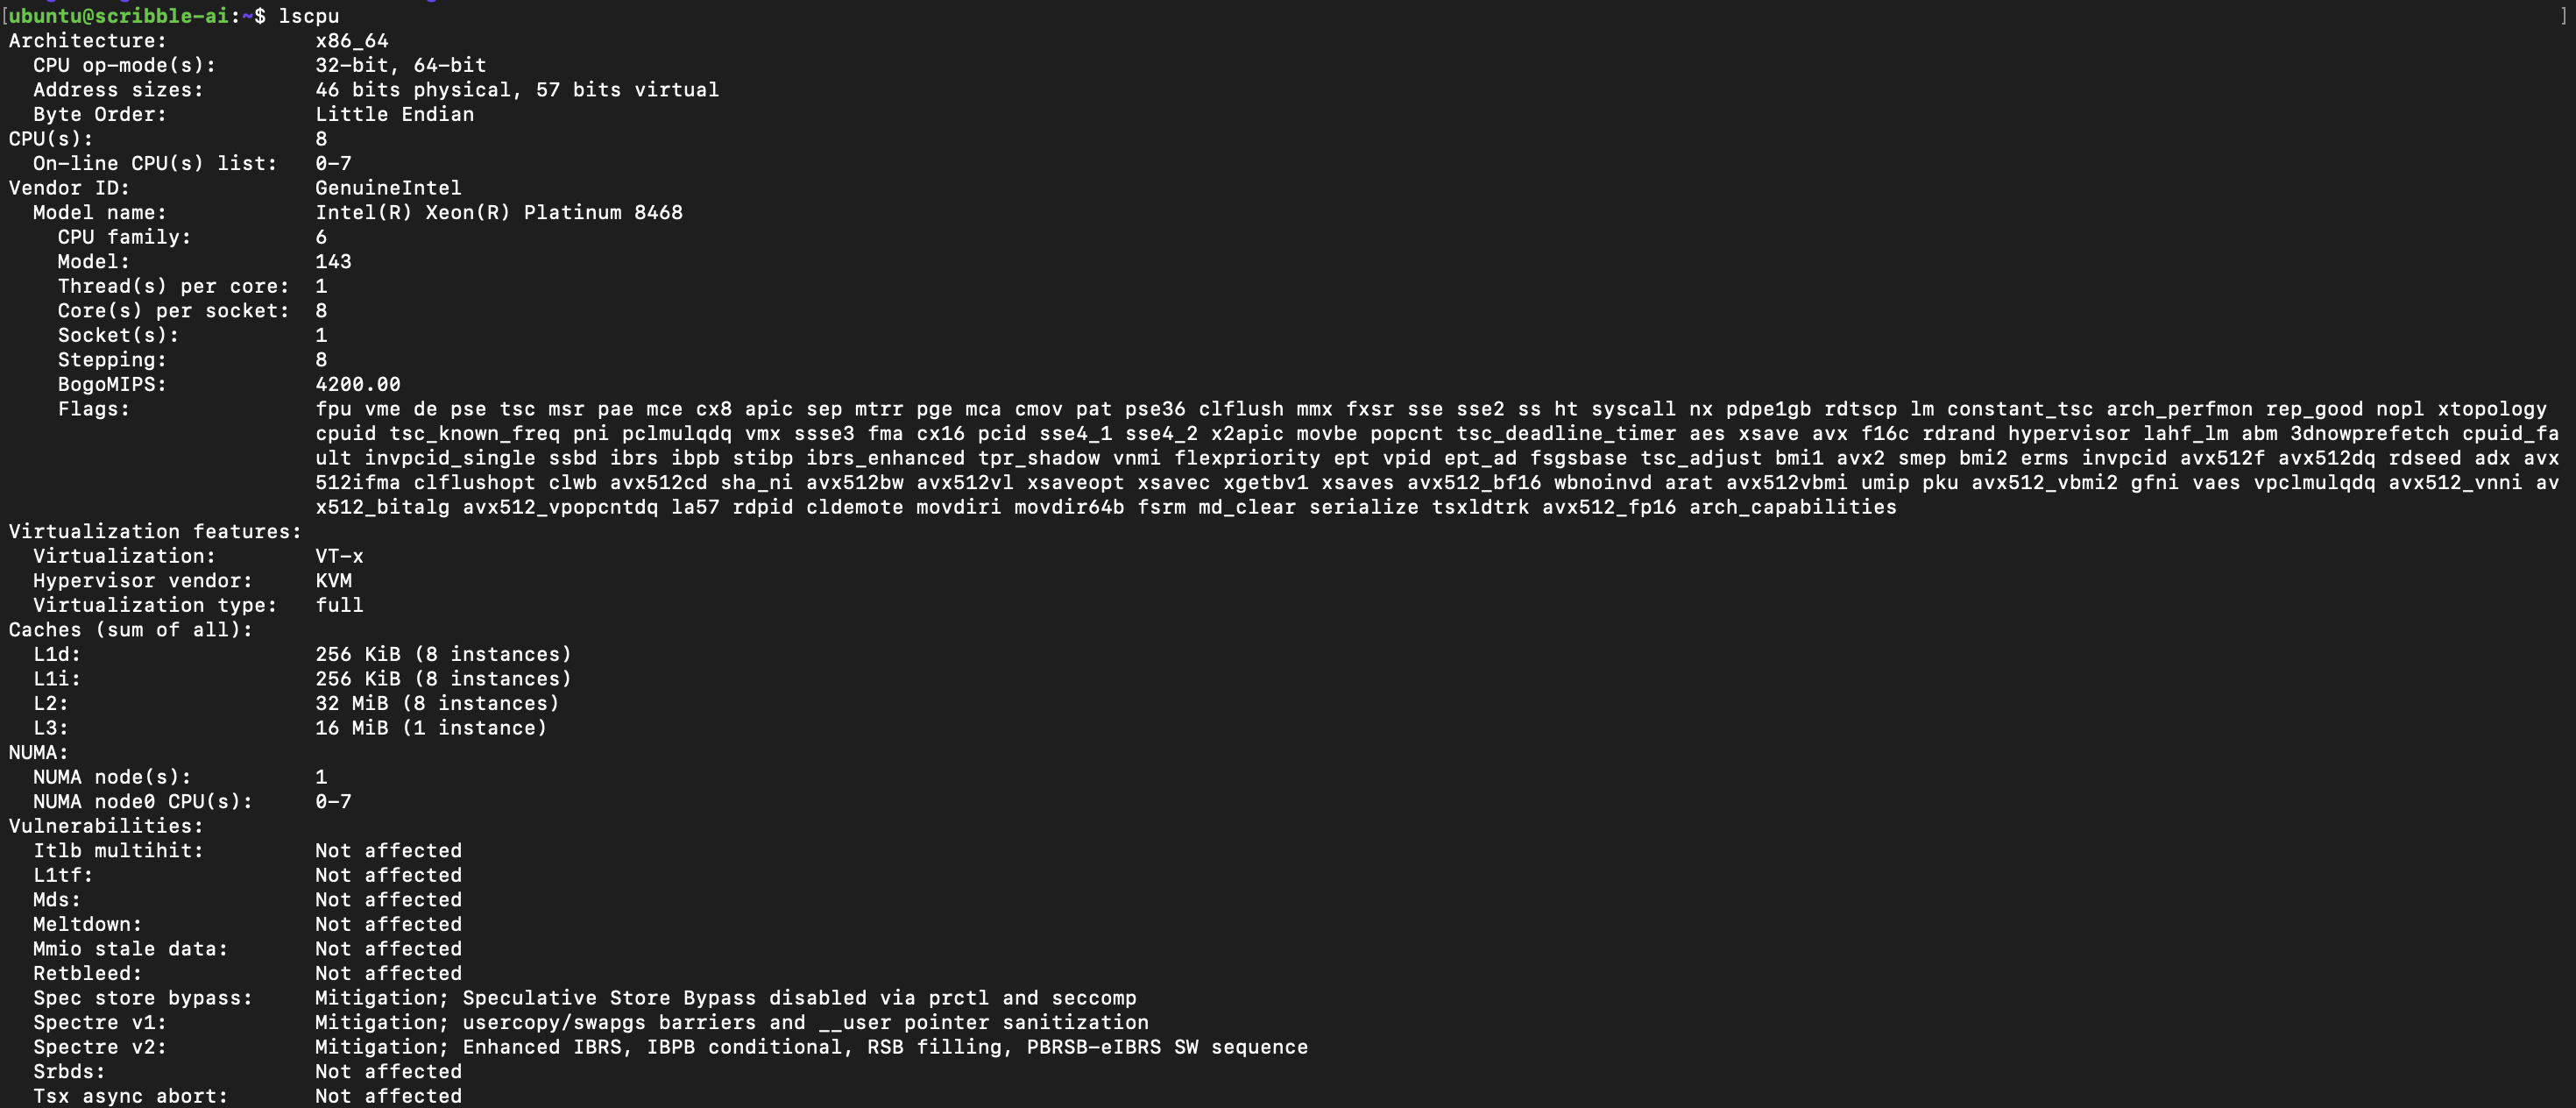

In [7]:
from IPython.display import Image
Image(filename='lscpu.png') 

## lscpu
As can See here there is no GPU we can use, we were limited to the CPU making generating the images on the cloud impossible to use